In [10]:
# Preamble: minimal imports + local include
using Random
using Statistics
using Printf
using Plots
using Logging

include("formatting.jl")

if !isdefined(Main, :System1D)
    include("../src/System1D.jl")
end
using .System1D: Hamiltonian, Walker, DMCParams, DMCSim, run_simulation!, plot_snapshot_1d_density


## System: 1D Harmonic Oscillator (No Importance Sampling)

**Potential**
$$ V(x) = \frac{1}{2} x^2 $$

**Trial wavefunction**
No importance sampling is used in this notebook (effectively $\psi_T(x)=1$).

This cell defines the Hamiltonian, initializes walkers, and runs the simulation.


In [11]:
# System: 1D harmonic oscillator
V(R) = 0.5 * R[1]^2
H = Hamiltonian(1, 0.5, V)

# Walkers and params
targetN = 5000
walkers = [Walker([2 * rand() - 1]) for _ in 1:targetN]

params = DMCParams(0.005, 400, 50, targetN, 0.5, 0.1, 10, 50)

# Run
rng_sim = MersenneTwister(42)
sim = DMCSim(H, params, walkers, rng_sim)
run_simulation!(sim; snapshot_steps=[params.nsteps])

ET_history = sim.ET_history
population_history = sim.population_history
energy_mean_history = sim.energy_mean_history
energy_variance_history = sim.energy_variance_history

nothing


## Results

**Exact ground-state energy**
$$ E_0 = \frac{1}{2} \; \text{(a.u.)} $$

This cell reports the post-equilibration energy and plots the reference energy, population, mean local energy, and local-energy variance over time, plus the final walker density.


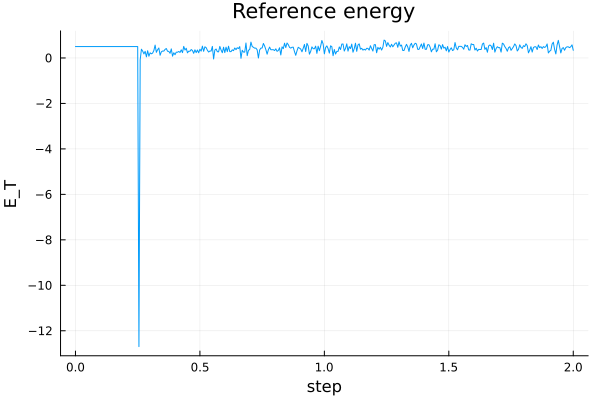

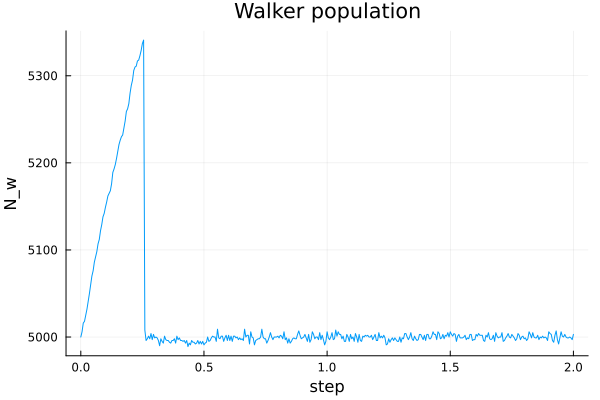

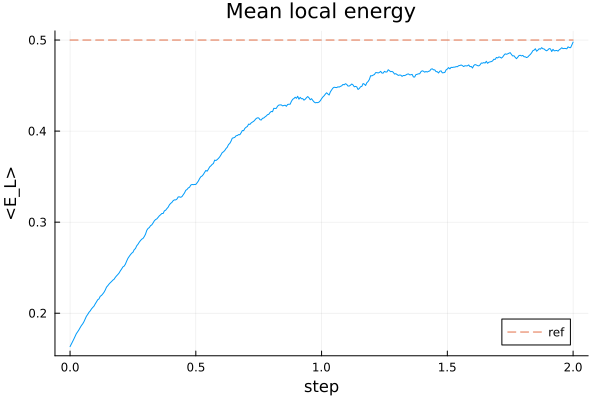

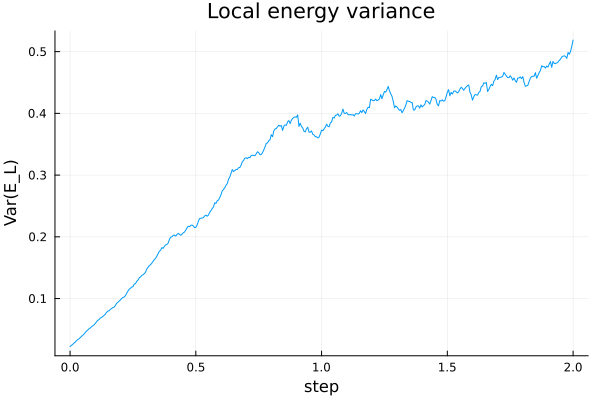

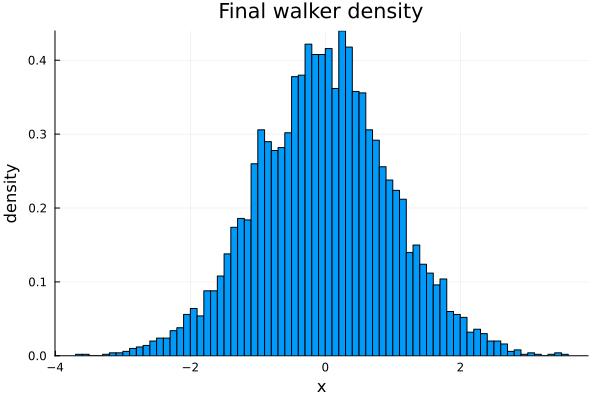

HO DMC energy (post-eq, nequil=50): E = 0.428 +/- 0.003
Final step: E = 0.50, Var(E_L) = 0.52
Reference energy: 0.50


In [12]:
# Results and plots
t = (0:params.nsteps) .* params.dt
E_ref = 0.5

nequil = params.nequil
start_idx = min(nequil + 1, length(energy_mean_history))
postE = energy_mean_history[start_idx:end]

Ebar = mean(postE)
SEM = (length(postE) > 1) ? std(postE) / sqrt(length(postE)) : NaN

Ebar_str, SEM_str = format_with_uncertainty(Ebar, SEM)
println("HO DMC energy (post-eq, nequil=$(nequil)): E = $(Ebar_str) +/- $(SEM_str)")
E_final_str, var_str = format_pair_sigfig(energy_mean_history[end], energy_variance_history[end]; sigfigs=2)
println("Final step: E = $(E_final_str), Var(E_L) = $(var_str)")
println("Reference energy: $(format_sigfig(E_ref; sigfigs=2))")


Logging.with_logger(Logging.NullLogger()) do
    redirect_stderr(devnull) do
        p1 = plot(t, ET_history, xlabel="step", ylabel="E_T", title="Reference energy", label=false)
        display(p1)
        
        p2 = plot(t, population_history, xlabel="step", ylabel="N_w", title="Walker population", label=false)
        display(p2)
        
        p3 = plot(t, energy_mean_history, xlabel="step", ylabel="<E_L>", title="Mean local energy", label=false)
        plot!(p3, [t[1], t[end]], [E_ref, E_ref], ls=:dash, label="ref")
        display(p3)
        
        p4 = plot(t, energy_variance_history, xlabel="step", ylabel="Var(E_L)", title="Local energy variance", label=false)
        display(p4)
        
        if !isempty(sim.walker_positions_history)
            snap = sim.walker_positions_history[end]
            p5 = plot_snapshot_1d_density(snap; nbins=120, title="Final walker density")
            display(p5)
        end
    end
end
